# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
import warnings

# Setup
warnings.filterwarnings("ignore")

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Read data
data = pd.read_csv(r'C:\Users\matui\IronLab\DAFT_905\module_2\Lab_20_Time-Series-Analysis\sub_1.csv')

Examine the data using the `head` function.

In [3]:
data.head(5)

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
data.isna().sum()

Unnamed: 0            0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
data.shape

(1751, 13)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=len(data))

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

Assign the time series index to the dataframe's index.

In [7]:
data.index = pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=len(data))

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](./images/tsa_decompose.png)

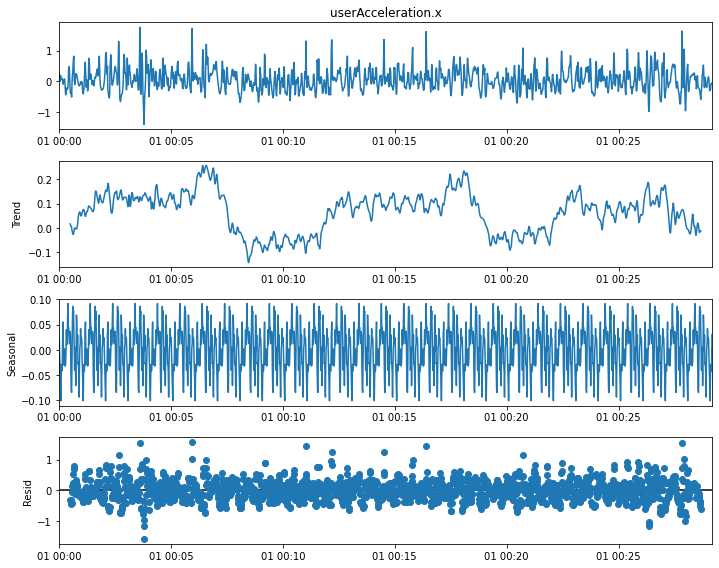

In [37]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


dec = seasonal_decompose(data['userAcceleration.x'], model='additive', freq=60)


plt.rcParams.update({'figure.figsize': (10,8)})
dec.plot()
plt.show()

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

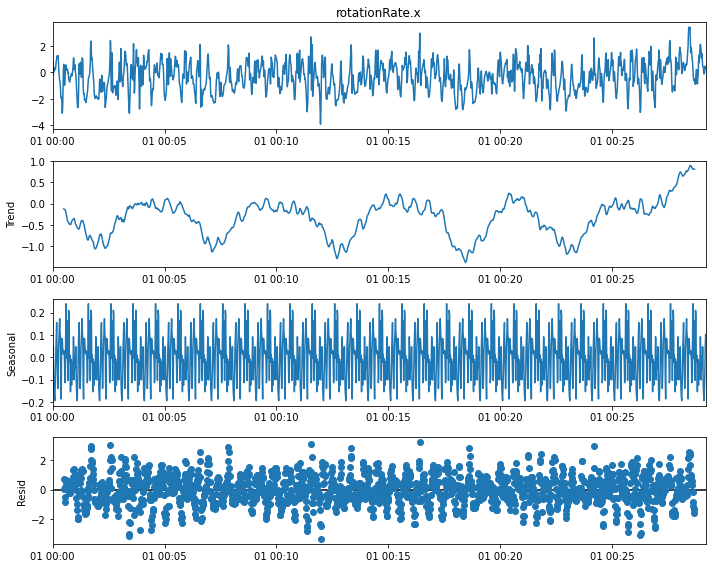

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


dec2 = seasonal_decompose(data['rotationRate.x'], model='additive', freq=60)


plt.rcParams.update({'figure.figsize': (10,8)})
dec2.plot()
plt.show()

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

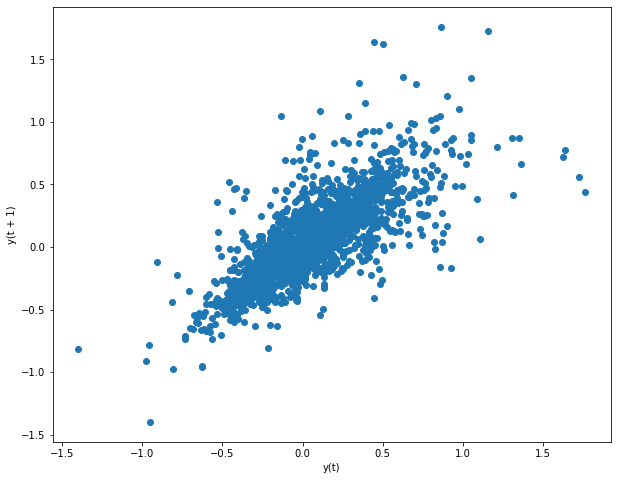

In [39]:
plt.rcParams.update({'figure.figsize': (10,8)})
pd.plotting.lag_plot(data['userAcceleration.x'], lag=1)

Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

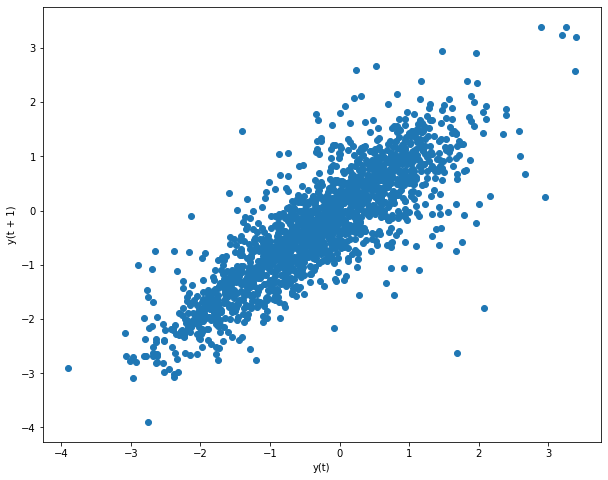

In [40]:
pd.plotting.lag_plot(data['rotationRate.x'], lag=1)

What are your conclusions from both visualizations?

```Comments:``` Autocorrelation in time series means that the series is linearly related to a lagged version of itself. For features 'rotationRate.x' and 'userAcceleration.x', the observations at time *t* have a positive linear correlation with the observations at time *t+1*. One of the assumptions of regression analysis is that the data has no autocorrelation. If we try to do a regression analysis on data with autocorrelation, then our analysis will be misleading.

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [42]:
# Ho: userAcceleration.x is not stationary
# Ha: userAcceleration.x is stationary

test = adfuller(data['userAcceleration.x'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value < 0.05, h0 rejected, meaning userAcceleration.x is stationary

ADF Statistic: -17.957994
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [43]:
test2 = adfuller(data['rotationRate.x'])
print('ADF Statistic: %f' % test2[0])
print('p-value: %f' % test2[1])
print('Critical Values:')
for key, value in test2[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value < 0.05, ha rejected, meaning rotationRate.x is not stationary

ADF Statistic: -5.269861
p-value: 0.000006
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


What are your conclusions from this test?

```Comments:``` ARMA models work on the assumption that the time series is stationary. Stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. In both cases, we can reject the null hypothesis that the time series is not stationary, so we can create an ARMA model.

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [46]:
from statsmodels.tsa.arima_model import ARMA
# ARMA of order (p,q)
# p: order of the autoregressive model (AR).
# q: order of the moving average model (MA).

In [47]:
train=data.iloc[:-10]
test=data.iloc[-10:]

In [48]:
arma = ARMA(train['userAcceleration.x'], order=(2,1)).fit()
print(arma.summary())

                              ARMA Model Results                              
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                     ARMA(2, 1)   Log Likelihood                 373.401
Method:                       css-mle   S.D. of innovations              0.195
Date:                Sun, 19 Jun 2022   AIC                           -736.803
Time:                        18:10:17   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0637      0.014      4.503      0.000       0.036       0.091
ar.L1.userAcceleration.x     0.9882      0.044     22.639      0.000       0.903       1.

In [50]:
predictions = arma.predict(test.index[0], end = test.index[-1])
predictions

2018-01-01 00:29:01    0.173148
2018-01-01 00:29:02    0.142896
2018-01-01 00:29:03    0.100522
2018-01-01 00:29:04    0.070106
2018-01-01 00:29:05    0.056099
2018-01-01 00:29:06    0.053778
2018-01-01 00:29:07    0.056790
2018-01-01 00:29:08    0.060646
2018-01-01 00:29:09    0.063316
2018-01-01 00:29:10    0.064493
Freq: S, dtype: float64

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [51]:
from statsmodels.tools.eval_measures import rmse

In [52]:
rmse(test['userAcceleration.x'], predictions)

0.2252986347767666

```Comments:``` 
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data, so how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction. We can say that the deviation from the true prediction is +/- 0.22.